
# pipeline for Enterotype identification


In [ ]:
## clean the environment
rm(list=ls())

In [81]:
###-----------------------------------------------------------------------------------------------------------------------
##### load required packages
###-----------------------------------------------------------------------------------------------------------------------
#' Data management
library(tidyverse)
library(dplyr)
#' Plots
library(ggalt)
library(ggplot2)
library(RColorBrewer)
library(khroma)
library(cowplot)
library(ggrepel)
#' Microbiota and clustering
library(factoextra)
#' Correspondance analysis
library(FactoMineR)

In [62]:
###-----------------------------------------------------------------------------------------------------------------------
##### theme for plot
###-----------------------------------------------------------------------------------------------------------------------
mycolor3= c("#E69F00","#56B4E9","#009E73")
##
mytheme=theme(legend.position = "right",
                #legend.justification = c(0,1),
                #legend.title = element_blank(),
                legend.text = element_text(size=8),
                legend.title = element_text(size=8),
                aspect.ratio = 2,
                #plot.margin = margin(t=5,r=20,b=5,l=20,unit="pt"),
                axis.title.y = element_text(size=8,colour="black"),
                axis.title.x = element_text(size=8,colour="black"),
                #axis.title.x = element_blank(),
                axis.text = element_text(size=8,colour="black",angle=0),
                axis.text.x = element_text(size=8,colour="black",angle=45,hjust=1),
                #axis.text.x = element_blank(),
                plot.title = element_text(size=8,face="bold",hjust = 0.5),
                panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour = "black", fill=NA, size=0.5),
                axis.line = element_line(colour = "black"),
                axis.ticks.length=unit(.1, "cm"),
                axis.ticks = element_line(colour = "black", size = 0.5)
  )

In [ ]:
##----------------------------------------------------------------
## load the metagenomic and clinical data
##----------------------------------------------------------------
load('input_data_for_enterotype_identification.RData')
# bact (the relative abundance which has been batch corrected)
# meta (clinical data of samples)

In [68]:
dim(meta);dim(bact)

[1] 782   3

In [69]:
### get the feature names
var_bact= colnames(bact)
length(var_bact)
###
input= cbind(meta, bact[rownames(meta),])
###
## setting parameters
max_dim <- 2
set.seed(42)
k <- 3
###
## ----------------------------------------------------------------
## PCoA analysis cluster
## ----------------------------------------------------------------
# Compute distance matrix
distance <- vegdist(input %>% select(all_of(var_bact)),method = 'gower')
distance <- sqrt(distance) # square-root transform to get positive PCoA eigen values
# Compute PCoA
pcoa <- cmdscale(distance, k = nrow(input)-1, eig = TRUE)
## ----------------------------------------------------------------
## Kmeans hierarchical clustering on PCoA1 and PCoA2
## ----------------------------------------------------------------
# Extract sample coordinates
data <- pcoa$points %>%
  as.data.frame.matrix() %>%
  rename_with(~ gsub("V", "PCoA", .x, fixed = TRUE))
##
optimal_cluster <- fviz_nbclust(data[, 1:max_dim], kmeans)
clust <- hkmeans(data[ , 1:max_dim], k = k)
#' Merge clusters with clinical data
samples <- data %>%
  rownames_to_column("Sample_ID") %>%
  left_join(meta, by = "Sample_ID") 
#
samples$clust = as.factor(clust$cluster)
###
samples$response_bin= samples$response_bin %>% factor(levels = c('responder','non_responder'))

[1] 1263

In [70]:
## ----------------------------------------------------------------
## rename the cluster and save
## ----------------------------------------------------------------
table(samples$clust)
#
library(DataCombine)
Replaces <- data.frame(from = c("1", "2","3"), 
                       to = c("cluster2","cluster1","cluster3"))
samples$cluster<- FindReplace(data = samples, Var = "clust", replaceData = Replaces,
                                     from = "from", to = "to",vector=TRUE)
samples$cluster=factor(samples$cluster, levels=c("cluster1", 'cluster2', 'cluster3'))
#
table(samples$cluster)


  1   2   3 
295 243 244 

Only exact matches will be replaced.




cluster1 cluster2 cluster3 
     243      295      244 

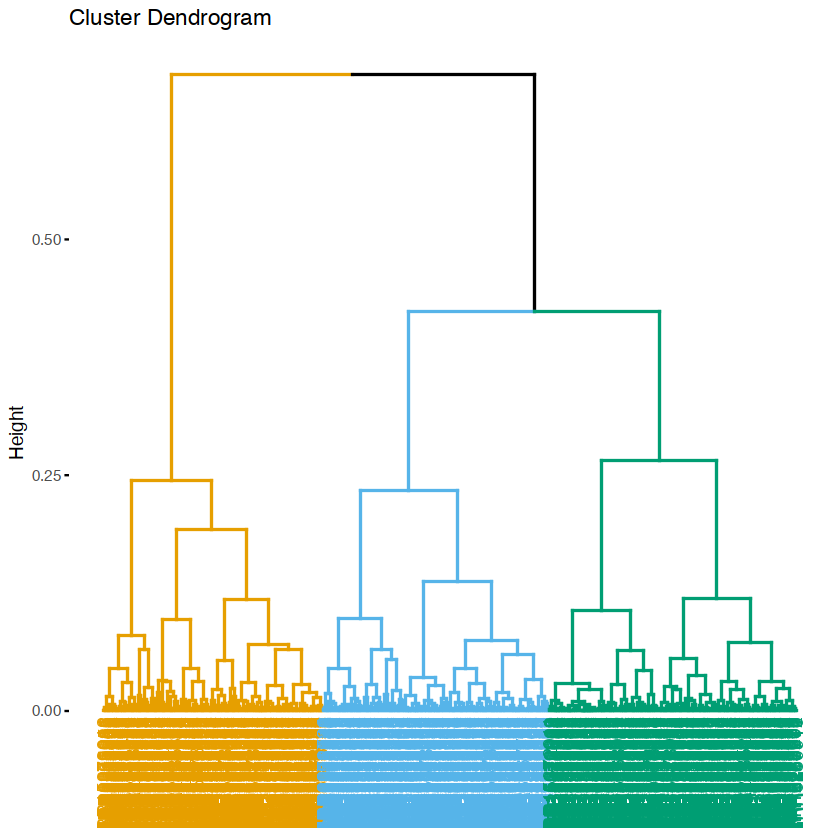

In [75]:
## ----------------------------------------------------------------
## Draw dendrogram clustering
## ----------------------------------------------------------------
#' Evaluate number of kmeans cluster
#optimal_cluster <- fviz_nbclust(data[, 1:max_dim], kmeans) # max_dim defined in get PCoA
fviz_dend(clust,type = c("rectangle", "circular", "phylogenic")[1],k_colors =mycolor3 )

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


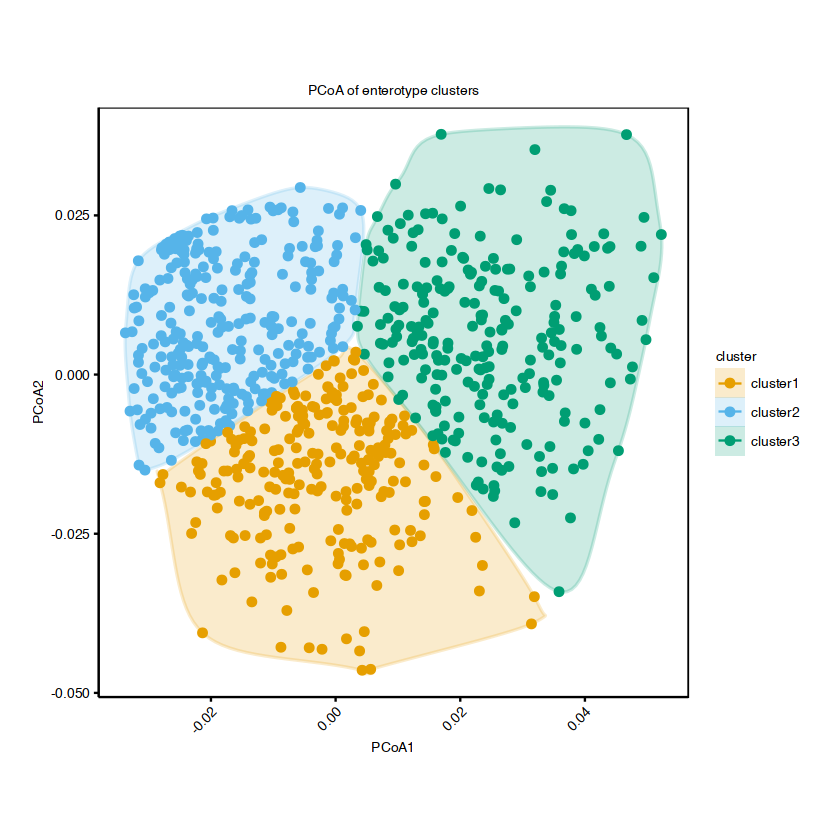

In [77]:
## ----------------------------------------------------------------
## Draw PCoA based on the results of the clustering
## ----------------------------------------------------------------
samples %>%
    #separate(azimut_id, into = c("allozithro_id", NA), sep = "_", remove = FALSE) %>% 
    ggplot(aes(x = PCoA1, y = PCoA2 )) +
    geom_encircle(aes(fill = cluster, color = cluster, group = cluster), expand = 0, alpha = 0.2, size = 2) +
    geom_line(aes(group = Sample_ID), linetype = "dashed", size = 0.2, color = "darkgrey") +
    geom_point(aes(color = cluster), size = 2) +
    scale_shape_manual(values = c(15, 18) ) +
    ggtitle('PCoA of enterotype clusters') +
    #scale_color_muted(name = "Cluster") +
    #scale_fill_muted(name = "Cluster") +
    #scale_fill_highcontrast(name = "Cluster")+
    #scale_color_highcontrast(name = "Cluster")+
    scale_color_manual(values=  mycolor3)+
    scale_fill_manual(values = mycolor3)+
    theme_minimal() +
    theme(legend.position = "right",
        #legend.justification = c(0,1),
        #legend.title = element_blank(),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        aspect.ratio = 1,
        plot.margin = margin(t=5,r=20,b=5,l=20,unit="pt"),
        axis.title.y = element_text(size=8,colour="black"),
        axis.title.x = element_text(size=8,colour="black"),
        #axis.title.x = element_blank(),
        axis.text = element_text(size=8,colour="black",angle=0),
        axis.text.x = element_text(size=8,colour="black",angle=45,hjust=1),
        #axis.text.x = element_blank(),
        plot.title = element_text(size=8,face="bold",hjust = 0.5),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_rect(colour = "black", fill=NA, size=0.5),
        axis.line = element_line(colour = "black"),
        axis.ticks.length=unit(.1, "cm"),
        axis.ticks = element_line(colour = "black", size = 0.5)
  )

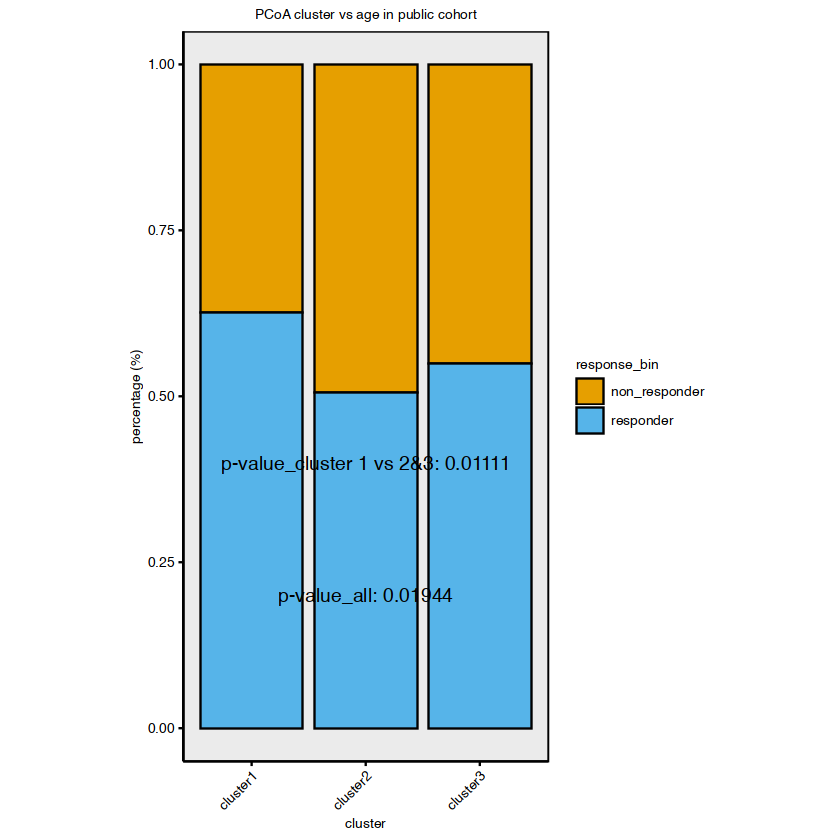

In [78]:
## ----------------------------------------------------------------
## Draw stacked plot response vs. clusters
## ----------------------------------------------------------------
##
stattmp=  samples
stattmp$response_bin=  factor(stattmp$response_bin, levels = c('non_responder','responder'))
p_all=fisher.test(stattmp$cluster, stattmp$response_bin)$p.value
###
stattmp$clust_comb= ifelse(stattmp$cluster=='cluster1','cluster1','cluster2and3')
###
p_clu1vs23=chisq.test(stattmp$clust_comb, stattmp$response_bin)$p.value
###
g1.2= ggplot(stattmp, aes(x=cluster, fill=response_bin)) + 
  geom_bar(position = "fill", colour="black")+
  scale_fill_manual(values = mycolor3)+
  mytheme+
  #coord_flip()+
  ylab('percentage (%)')+ggtitle('PCoA cluster vs age in public cohort')+
  guides(color = guide_legend(ncol = 2, byrow = TRUE))+
  annotate("text", x=2, y=0.2, label=paste0("p-value_all: ",signif(p_all,4)),size=4)+
  annotate("text", x=2,y=0.4, label=paste0("p-value_cluster 1 vs 2&3: ",signif(p_clu1vs23,4)),size=4)#+
  #annotate("text", x=1.5, y=0.6, label=paste0("p-p_clu1vs2: ",signif(p_clu1vs2,4)),size=4)+
  #annotate("text", x=1, y=0.8, label=paste0("p-p_clu1vs3: ",signif(p_clu1vs3,4)),size=4)
#pdf(paste0(outDir,'EADEAE_vs_response_chisqtest.pdf'),width = 3.5,height = 6)
g1.2
#dev.off()

In [79]:
## ----------------------------------------------------------------
## Draw stacked plot age range vs. clusters
## ----------------------------------------------------------------
stattmp= samples
stattmp$age_bin5= cut(stattmp$age, 
                 breaks = c(min(stattmp$age),30,40,50,60,70, max(stattmp$age)),
                 labels = c("<30",'30-40','40-50','50-60','60-70','>70'), include.lowest = TRUE)

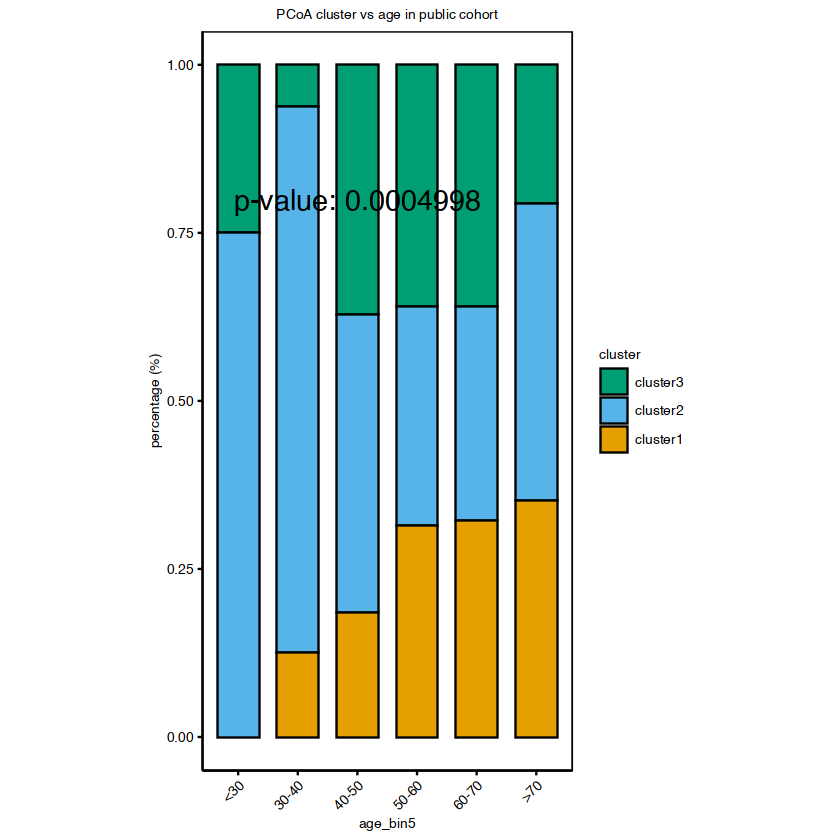

In [80]:
pval <- fisher.test(stattmp$cluster, stattmp$age_bin5,simulate.p.value = T)$p.value
stattmp %>% mutate(cluster =  factor(cluster,  levels = c('cluster3','cluster2','cluster1'))) %>% 
ggplot(aes(x=age_bin5, fill=cluster)) + 
  #geom_bar(position = "fill", colour="black")+
  scale_fill_manual(values = rev(mycolor3))+
geom_bar(position = "fill", colour="black",width=0.7)+
  theme_minimal()+
  mytheme+
  #coord_flip()+
  ylab('percentage (%)')+ggtitle('PCoA cluster vs age in public cohort')+
  guides(color = guide_legend(ncol = 2, byrow = TRUE))+
  annotate("text", x=3, y=0.8, label=paste0("p-value: ",signif(pval,4)),size=6)